DDPM : Denoising Diffusion Probabilistic Models

- Ref: 
    - DDPM: https://github.com/MaximeVandegar/Papers-in-100-Lines-of-Code/tree/main/Denoising_Diffusion_Probabilistic_Models




In [1]:
import os
import torch
import torch.nn as nn
import numpy as np

import math
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchsummary import summary
import torchshow as ts

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torchvision.transforms.functional as F
from pathlib import Path

import time


In [2]:
## Unet network model
# Ref: https://github.com/MaximeVandegar/Papers-in-100-Lines-of-Code/blob/main/Denoising_Diffusion_Probabilistic_Models/unet.py

def get_timestep_embedding(timesteps, embedding_dim: int):
    """
    Retrieved from https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/nn.py#LL90C1-L109C13
    """
    assert len(timesteps.shape) == 1

    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=timesteps.device) * -emb)
    emb = timesteps.type(torch.float32)[:, None] * emb[None, :]
    emb = torch.concat([torch.sin(emb), torch.cos(emb)], axis=1)

    if embedding_dim % 2 == 1:  # zero pad
        emb = torch.nn.functional.pad(emb, (0, 1, 0, 0))

    assert emb.shape == (timesteps.shape[0], embedding_dim), f"{emb.shape}"
    return emb


class Downsample(nn.Module):

    def __init__(self, C):
        """
        :param C (int): number of input and output channels
        """
        super(Downsample, self).__init__()
        self.conv = nn.Conv2d(C, C, 3, stride=2, padding=1)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.conv(x)
        assert x.shape == (B, C, H // 2, W // 2)
        return x


class Upsample(nn.Module):

    def __init__(self, C):
        """
        :param C (int): number of input and output channels
        """
        super(Upsample, self).__init__()
        self.conv = nn.Conv2d(C, C, 3, stride=1, padding=1)

    def forward(self, x):
        B, C, H, W = x.shape

        x = nn.functional.interpolate(x, size=None, scale_factor=2, mode='nearest')

        x = self.conv(x)
        assert x.shape == (B, C, H * 2, W * 2)
        return x


class Nin(nn.Module):

    def __init__(self, in_dim, out_dim, scale=1e-10):
        super(Nin, self).__init__()

        n = (in_dim + out_dim) / 2
        limit = np.sqrt(3 * scale / n)
        self.W = torch.nn.Parameter(torch.zeros((in_dim, out_dim), dtype=torch.float32
                                                ).uniform_(-limit, limit))
        self.b = torch.nn.Parameter(torch.zeros((1, out_dim, 1, 1), dtype=torch.float32))

    def forward(self, x):
        return torch.einsum('bchw, co->bohw', x, self.W) + self.b


class ResNetBlock(nn.Module):

    def __init__(self, in_ch, out_ch, dropout_rate=0.1):
        super(ResNetBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
        self.dense = nn.Linear(512, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1)

        if not (in_ch == out_ch):
            self.nin = Nin(in_ch, out_ch)

        self.dropout_rate = dropout_rate
        self.nonlinearity = torch.nn.SiLU()

    def forward(self, x, temb):
        """
        :param x: (B, C, H, W)
        :param temb: (B, dim)
        """

        h = self.nonlinearity(nn.functional.group_norm(x, num_groups=32))
        h = self.conv1(h)

        # add in timestep embedding
        h += self.dense(self.nonlinearity(temb))[:, :, None, None]

        h = self.nonlinearity(nn.functional.group_norm(h, num_groups=32))
        h = nn.functional.dropout(h, p=self.dropout_rate)
        h = self.conv2(h)

        if not (x.shape[1] == h.shape[1]):
            x = self.nin(x)

        assert x.shape == h.shape
        return x + h


class AttentionBlock(nn.Module):

    def __init__(self, ch):
        super(AttentionBlock, self).__init__()

        self.Q = Nin(ch, ch)
        self.K = Nin(ch, ch)
        self.V = Nin(ch, ch)

        self.ch = ch

        self.nin = Nin(ch, ch, scale=0.)

    def forward(self, x):
        B, C, H, W = x.shape
        assert C == self.ch

        h = nn.functional.group_norm(x, num_groups=32)
        q = self.Q(h)
        k = self.K(h)
        v = self.V(h)

        w = torch.einsum('bchw,bcHW->bhwHW', q, k) * (int(C) ** (-0.5))  # [B, H, W, H, W]
        w = torch.reshape(w, [B, H, W, H * W])
        w = torch.nn.functional.softmax(w, dim=-1)
        w = torch.reshape(w, [B, H, W, H, W])

        h = torch.einsum('bhwHW,bcHW->bchw', w, v)
        h = self.nin(h)

        assert h.shape == x.shape
        return x + h


class UNet(nn.Module):

    def __init__(self, ch=128, in_ch=1):
        super(UNet, self).__init__()

        self.ch = ch
        self.linear1 = nn.Linear(ch, 4 * ch)
        self.linear2 = nn.Linear(4 * ch, 4 * ch)

        self.conv1 = nn.Conv2d(in_ch, ch, 3, stride=1, padding=1)

        self.down = nn.ModuleList([ResNetBlock(ch, 1 * ch),
                                   ResNetBlock(1 * ch, 1 * ch),
                                   Downsample(1 * ch),
                                   ResNetBlock(1 * ch, 2 * ch),
                                   AttentionBlock(2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch),
                                   AttentionBlock(2 * ch),
                                   Downsample(2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch),
                                   Downsample(2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch)])

        self.middle = nn.ModuleList([ResNetBlock(2 * ch, 2 * ch),
                                     AttentionBlock(2 * ch),
                                     ResNetBlock(2 * ch, 2 * ch)])

        self.up = nn.ModuleList([ResNetBlock(4 * ch, 2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 Upsample(2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 Upsample(2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 AttentionBlock(2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 AttentionBlock(2 * ch),
                                 ResNetBlock(3 * ch, 2 * ch),
                                 AttentionBlock(2 * ch),
                                 Upsample(2 * ch),
                                 ResNetBlock(3 * ch, ch),
                                 ResNetBlock(2 * ch, ch),
                                 ResNetBlock(2 * ch, ch)])

        self.final_conv = nn.Conv2d(ch, in_ch, 3, stride=1, padding=1)

    def forward(self, x, t):
        """
        :param x: (torch.Tensor) batch of images [B, C, H, W]
        :param t: (torch.Tensor) tensor of time steps (torch.long) [B]
        """

        temb = get_timestep_embedding(t, self.ch)
        temb = torch.nn.functional.silu(self.linear1(temb))
        temb = self.linear2(temb)
        assert temb.shape == (t.shape[0], self.ch * 4)

        x1 = self.conv1(x)

        # Down
        x2 = self.down[0](x1, temb)
        x3 = self.down[1](x2, temb)
        x4 = self.down[2](x3)
        x5 = self.down[3](x4, temb)
        x6 = self.down[4](x5)  # Attention
        x7 = self.down[5](x6, temb)
        x8 = self.down[6](x7)  # Attention
        x9 = self.down[7](x8)
        x10 = self.down[8](x9, temb)
        x11 = self.down[9](x10, temb)
        x12 = self.down[10](x11)
        x13 = self.down[11](x12, temb)
        x14 = self.down[12](x13, temb)

        # Middle
        x = self.middle[0](x14, temb)
        x = self.middle[1](x)
        x = self.middle[2](x, temb)

        # Up
        x = self.up[0](torch.cat((x, x14), dim=1), temb)
        x = self.up[1](torch.cat((x, x13), dim=1), temb)
        x = self.up[2](torch.cat((x, x12), dim=1), temb)
        x = self.up[3](x)
        x = self.up[4](torch.cat((x, x11), dim=1), temb)
        x = self.up[5](torch.cat((x, x10), dim=1), temb)
        x = self.up[6](torch.cat((x, x9), dim=1), temb)
        x = self.up[7](x)
        x = self.up[8](torch.cat((x, x8), dim=1), temb)
        x = self.up[9](x)
        x = self.up[10](torch.cat((x, x6), dim=1), temb)
        x = self.up[11](x)
        x = self.up[12](torch.cat((x, x4), dim=1), temb)
        x = self.up[13](x)
        x = self.up[14](x)
        x = self.up[15](torch.cat((x, x3), dim=1), temb)
        x = self.up[16](torch.cat((x, x2), dim=1), temb)
        x = self.up[17](torch.cat((x, x1), dim=1), temb)

        x = nn.functional.silu(nn.functional.group_norm(x, num_groups=32))
        x = self.final_conv(x)

        return x


- DDPM
    - ![DDPM](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FRXOe5%2Fbtru2nyl2SU%2FzkLx0SMgf1qpaI01kCmGu1%2Fimg.png)

In [3]:
# Diffusion Model

class DiffusionModel:

    def __init__(self, T: int, model: nn.Module, device: str):
        self.T = T
        self.function_approximator = model.to(device)
        self.device = device

        self.beta = torch.linspace(1e-4, 0.02, T).to(device)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

        # DPM_SOLVER
        self.alphas = torch.sqrt(self.alpha_bar)
        self.sigmas = torch.sqrt(1.0 - self.alpha_bar)
        self.lambdas = torch.log(self.alphas / self.sigmas)

    def training(self, x0, batch_size, optimizer):
        """
        Algorithm 1 in Denoising Diffusion Probabilistic Models
        """

        # x0 = sample_batch(batch_size, self.device)
        t = torch.randint(1, self.T + 1, (batch_size,), device=self.device,
                          dtype=torch.long)
        eps = torch.randn_like(x0)

        # Take one gradient descent step
        alpha_bar_t = self.alpha_bar[t - 1].unsqueeze(-1).unsqueeze(
            -1).unsqueeze(-1)
        eps_predicted = self.function_approximator(torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * eps, t - 1)
        loss = nn.functional.mse_loss(eps, eps_predicted)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss.item()

    @torch.no_grad()
    def sampling(self, n_samples=1, image_channels=1, img_size=(32, 32), sample_it = 10):
        """
        Algorithm 2 in Denoising Diffusion Probabilistic Models
        """
        t_lst = []
        x = torch.randn((n_samples, image_channels, img_size[0], img_size[1]),
                        device=self.device)
        for it in tqdm(range(self.T, 0, -1), desc="Sampling"):
            if it % sample_it == 0:
                t_lst.append((it, x))
            z = torch.randn_like(x) if it > 1 else torch.zeros_like(x)
            t = torch.ones(n_samples, dtype=torch.long, device=self.device) * it

            beta_t = self.beta[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            alpha_t = self.alpha[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            alpha_bar_t = self.alpha_bar[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

            mean = 1 / torch.sqrt(alpha_t) * (x - ((1 - alpha_t) / torch.sqrt(
                1 - alpha_bar_t)) * self.function_approximator(x, t - 1))
            sigma = torch.sqrt(beta_t)
            x = mean + sigma * z
        t_lst.append((it-1, x))
        return x, t_lst

    @torch.no_grad()
    def ddpm_sampling(self, n_samples=1, image_channels=1, img_size=(32, 32),
                 use_tqdm=True):
        """
        Algorithm 2 in Denoising Diffusion Probabilistic Models
        """

        x = torch.randn((n_samples, image_channels, img_size[0], img_size[1]),
                        device=self.device)
        progress_bar = tqdm if use_tqdm else lambda x: x
        # for t in progress_bar(range(self.T, 0, -1)):
        for t in tqdm(range(self.T, 0, -1), desc="DDPM Sampling"):
            z = torch.randn_like(x) if t > 1 else torch.zeros_like(x)
            t = torch.ones(n_samples, dtype=torch.long, device=self.device) * t

            beta_t = self.beta[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            alpha_t = self.alpha[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            alpha_bar_t = self.alpha_bar[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

            mean = 1 / torch.sqrt(alpha_t) * (x - ((1 - alpha_t) / torch.sqrt(
                1 - alpha_bar_t)) * self.function_approximator(x, t - 1))
            sigma = torch.sqrt(beta_t)
            x = mean + sigma * z
        return x

    @torch.no_grad()
    def ddim_sampling(self, n_samples=1, image_channels=1, img_size=(32, 32),
                      n_steps=50, use_tqdm=True):

        step_size = self.T // n_steps
        x = torch.randn((n_samples, image_channels, img_size[0], img_size[1]),
                        device=self.device)
        progress_bar = tqdm if use_tqdm else lambda x: x

        # for i in progress_bar(range(n_steps)):
        for i in tqdm(range(n_steps), desc="DDIM Sampling"):
            t = self.T - i * step_size
            t_tensor = torch.ones(n_samples, dtype=torch.long, device=self.device) * t

            alpha_bar_t = self.alpha_bar[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            alpha_bar_prev = self.alpha_bar[t - step_size - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1) if t > step_size else torch.tensor(1.0).to(self.device)

            # Predicted noise
            eps_pred = self.function_approximator(x, t_tensor - 1)

            # Predicted x_0
            x0_pred = (x - torch.sqrt(1 - alpha_bar_t) * eps_pred) / torch.sqrt(alpha_bar_t)

            # Direction pointing to xt
            dir_xt = torch.sqrt(1 - alpha_bar_prev) * eps_pred

            # Update rule
            x = torch.sqrt(alpha_bar_prev) * x0_pred + dir_xt

        return x

    @torch.no_grad()
    def dpm_solver_sampling(self, n_samples=1, image_channels=1, img_size=(32, 32), n_steps=10, use_tqdm=True):
        """
        DPM-Solver-2 (Algorithm 1 from https://arxiv.org/pdf/2206.00927).
        """
        step_size = self.T // n_steps
        # start from Gaussian noise x_T
        xT = torch.randn((n_samples, image_channels, img_size[0], img_size[1]), device=self.device)
        x_tilde = xT

        for i in tqdm(range(n_steps), desc="DPM-Solver Sampling", disable=not use_tqdm):

            t_prev = self.T - i * step_size
            t_cur = max(t_prev - step_size, 1)

            # midpoint in λ-space
            lam_mid = (self.lambdas[t_prev - 1] + self.lambdas[t_cur - 1]) / 2.
            # invert λ→t via nearest neighbor lookup
            s_i = torch.argmin(torch.abs(self.lambdas - lam_mid)).item() + 1

            # λ-step size
            h = self.lambdas[t_cur - 1] - self.lambdas[t_prev - 1]

            # model evaluation at t_prev
            t_prev_tensor = torch.full((n_samples,), t_prev, dtype=torch.long, device=self.device)
            u_i = (self.alphas[s_i - 1] / self.alphas[t_prev - 1]) * x_tilde - self.sigmas[s_i - 1] * (
                torch.exp(h * 0.5) - 1) * self.function_approximator(x_tilde, t_prev_tensor - 1)

            t_s_tensor = torch.full((n_samples,), s_i, dtype=torch.long, device=self.device)
            x_tilde = (self.alphas[t_cur - 1] / self.alphas[t_prev - 1]) * x_tilde - self.sigmas[t_cur - 1] * (
                torch.exp(h) - 1) * self.function_approximator(u_i, t_s_tensor - 1)

        return x_tilde

In [4]:
if torch.backends.mps.is_available():
    g_device = torch.device("mps")
    print(f"Current memory allocated on MPS: {torch.mps.current_allocated_memory()} bytes")
    print(f"Driver memory allocated on MPS: {torch.mps.driver_allocated_memory()} bytes")
elif torch.cuda.is_available():
    g_device = torch.device("cuda")
else:
    g_device = torch.device("cpu")
print(g_device)

Current memory allocated on MPS: 0 bytes
Driver memory allocated on MPS: 393216 bytes
mps


In [5]:

def save_video(img_t_lst, nrows = 9, ncols = 9, v_fp = "test.mp4"):
    # fig, axes = plt.subplots(nrows, ncols, figsize=(6, 6))
    fig, axes = plt.subplots(nrows, ncols)
    ims = []
    for i, imt in img_t_lst:
        frame_ims = []
        if not isinstance(i, int):
            i = i[0]
        for j, ax in enumerate(axes.flat):
            # print(f"{i}_{j}")
            # ax.set_title(f"{i}_{j}")
            ax.axis('off')
            frame_ims.append(ax.imshow(F.to_pil_image(imt[j].to("cpu").clip(0, 1)), cmap='gray'))
        ims.append(frame_ims)
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    # vfp = os.path.join(g_video_path, v_fname)
    ani.save(v_fp, writer="ffmpeg", fps=10)

Epoch - 0


Sampling: 100%|██████████| 1000/1000 [00:30<00:00, 32.95it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/Diffusion_00_MNIST_videos/test_000.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [00:30<00:00, 33.21it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 30.111337900161743 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 32.76it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.5277388095855713 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 13.51it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.7415530681610107 seconds
Epoch - 1


DDPM Sampling: 100%|██████████| 1000/1000 [00:29<00:00, 33.35it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 29.987114906311035 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 33.61it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.4891462326049805 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 15.99it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.6265249252319336 seconds
Epoch - 2


DDPM Sampling: 100%|██████████| 1000/1000 [00:29<00:00, 33.50it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 29.847867965698242 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 32.38it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.5456128120422363 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 15.97it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.627467155456543 seconds
Epoch - 3


DDPM Sampling: 100%|██████████| 1000/1000 [00:29<00:00, 33.59it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 29.76765489578247 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 32.32it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.547975778579712 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 16.14it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.6206917762756348 seconds
Epoch - 4


DDPM Sampling: 100%|██████████| 1000/1000 [00:30<00:00, 33.26it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 30.065083742141724 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 31.80it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.5736138820648193 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 15.45it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.6482698917388916 seconds
Epoch - 5


Sampling: 100%|██████████| 1000/1000 [00:29<00:00, 34.15it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/Diffusion_00_MNIST_videos/test_005.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [00:29<00:00, 34.17it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 29.26871395111084 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 33.45it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.496164083480835 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 15.85it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.6319971084594727 seconds
Epoch - 6


DDPM Sampling: 100%|██████████| 1000/1000 [00:30<00:00, 33.01it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 30.292716026306152 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 32.77it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.526944875717163 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 16.75it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.5984940528869629 seconds
Epoch - 7


DDPM Sampling: 100%|██████████| 1000/1000 [00:28<00:00, 35.61it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 28.08502984046936 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 34.52it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.4495129585266113 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 17.33it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.5779528617858887 seconds
Epoch - 8


DDPM Sampling: 100%|██████████| 1000/1000 [00:28<00:00, 35.54it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 28.14214301109314 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 34.77it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.4391229152679443 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 16.64it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.6022651195526123 seconds
Epoch - 9


DDPM Sampling: 100%|██████████| 1000/1000 [00:28<00:00, 35.52it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 28.15224313735962 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 34.86it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.4356529712677002 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 16.69it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.6004350185394287 seconds
Epoch - 10


Sampling: 100%|██████████| 1000/1000 [00:27<00:00, 35.73it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/Diffusion_00_MNIST_videos/test_010.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [00:28<00:00, 35.58it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 28.10714292526245 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 34.20it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.463301181793213 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 16.56it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.6049971580505371 seconds
Epoch - 11


DDPM Sampling: 100%|██████████| 1000/1000 [00:28<00:00, 35.51it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 28.15959882736206 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 34.27it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.460184097290039 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 16.95it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.5912477970123291 seconds
Epoch - 12


DDPM Sampling: 100%|██████████| 1000/1000 [00:28<00:00, 35.41it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 28.240389823913574 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 34.22it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.4624319076538086 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 16.82it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.5956521034240723 seconds
Epoch - 13


DDPM Sampling: 100%|██████████| 1000/1000 [00:27<00:00, 35.93it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 27.83445382118225 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 35.87it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.3950650691986084 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 17.66it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.5672359466552734 seconds
Epoch - 14


DDPM Sampling: 100%|██████████| 1000/1000 [00:27<00:00, 35.90it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 27.856010913848877 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 35.86it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.3954486846923828 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 17.82it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.562047004699707 seconds
Epoch - 15


Sampling: 100%|██████████| 1000/1000 [00:27<00:00, 35.93it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/Diffusion_00_MNIST_videos/test_015.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [00:27<00:00, 35.90it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 27.859853744506836 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 35.18it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.4222729206085205 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 17.61it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.5690028667449951 seconds
Epoch - 16


DDPM Sampling: 100%|██████████| 1000/1000 [00:29<00:00, 33.77it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 29.612315893173218 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 33.52it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.4933891296386719 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 16.99it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.5897316932678223 seconds
Epoch - 17


DDPM Sampling: 100%|██████████| 1000/1000 [00:29<00:00, 33.96it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 29.4513258934021 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 33.87it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.477599859237671 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 16.21it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.6179409027099609 seconds
Epoch - 18


DDPM Sampling: 100%|██████████| 1000/1000 [00:28<00:00, 35.16it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 28.44489622116089 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 33.43it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.4969470500946045 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 16.80it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DPM-Solver-Sampling 0.5966081619262695 seconds
Epoch - 19


Sampling: 100%|██████████| 1000/1000 [00:28<00:00, 35.32it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/Diffusion_00_MNIST_videos/test_019.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [00:28<00:00, 35.28it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDPM-Sampling 28.345005750656128 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:01<00:00, 34.35it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


DDIM-Sampling 1.4565610885620117 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:00<00:00, 16.76it/s]

DPM-Solver-Sampling 0.5979137420654297 seconds



/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:385: UserWarning: Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.
  warnings.warn('Original input range is not 0-1 when using grayscale mode. Auto-rescaling it to 0-1 by default.')


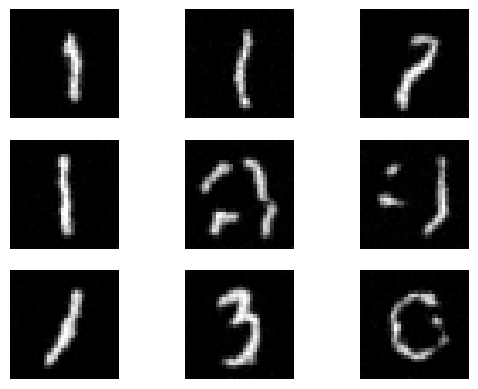

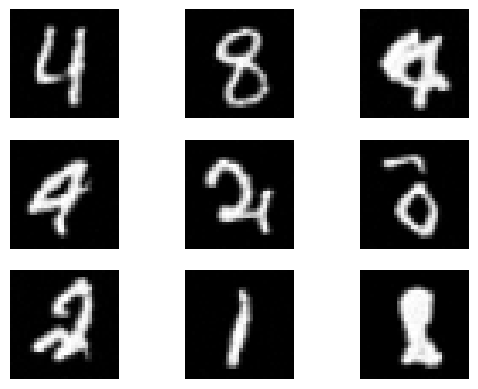

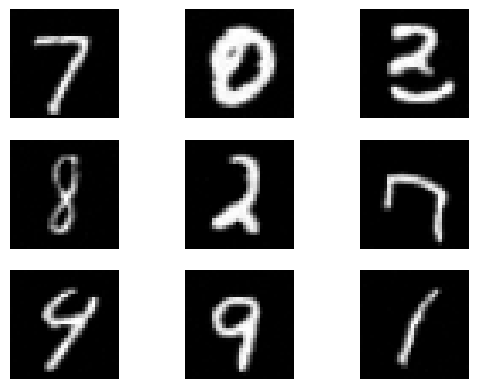

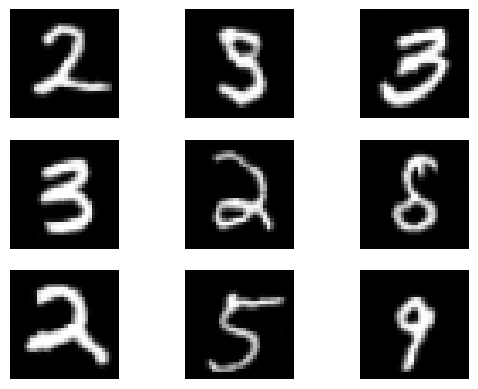

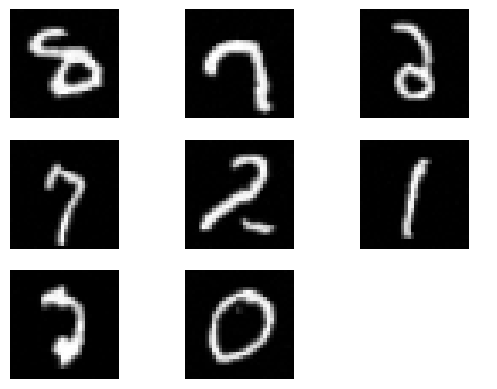

In [6]:
g_model_path = './temp/Diffusion_00_MNIST_models/'
g_video_path = './temp/Diffusion_00_MNIST_videos/'
Path(g_model_path).mkdir(exist_ok=True, parents=True)
Path(g_video_path).mkdir(exist_ok=True, parents=True)


# parameters
batch_size = 32
epoches = 20
nb_images = 9
img_channel = 1

# datasets
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((32,32),interpolation=transforms.InterpolationMode.BILINEAR, antialias=True)
            ])
dataset = datasets.MNIST(root='./temp/data', train=True, download=True, transform=transform)
len(dataset)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Setup Model
model = UNet(in_ch = img_channel)
model.to(g_device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
diffusion_model = DiffusionModel(1000, model, g_device)

# Training
loss_lst = []
for ep in range(epoches):
    print(f"Epoch - {ep}")
    tq = tqdm(enumerate(dataloader), total = len(dataloader), desc="Training")
    for i, x0, in tq:
        x0 = x0[0].to(g_device)
        _loss = diffusion_model.training(x0, batch_size, optimizer)
        loss_lst.append(_loss)
        tq.set_description(f"Loss: {_loss:.5f}; step {i}; epoch {ep}")

    _model_path = os.path.join(g_model_path, f'unet_{ep:03d}.pth')
    torch.save(diffusion_model.function_approximator.state_dict(), _model_path)

    diffusion_model.function_approximator.eval()
    if ep % 5 == 0 or ep == epoches-1:
        _, t_list = diffusion_model.sampling(n_samples=nb_images, image_channels=img_channel, img_size=(32, 32))
        vfp = os.path.join(g_video_path, f"test_{ep:03d}.mp4")
        save_video(t_list, 3, 3, vfp)


    st = time.time()
    samples = diffusion_model.ddpm_sampling(n_samples=nb_images, image_channels=img_channel, img_size=(32, 32), use_tqdm=True)
    print(f"DDPM-Sampling {time.time() - st } seconds")
    img_op = os.path.join(g_video_path, f"ddpm_{ep:03d}.jpg")
    ts.save(samples, img_op, ncols = 3)

    st = time.time()
    samples = diffusion_model.ddim_sampling(n_samples=nb_images, image_channels=img_channel, img_size=(32, 32), use_tqdm=True)
    print(f"DDIM-Sampling {time.time() - st } seconds")
    img_op = os.path.join(g_video_path, f"ddim_{ep:03d}.jpg")
    ts.save(samples, img_op, ncols = 3)

    st = time.time()
    samples = diffusion_model.dpm_solver_sampling(n_samples=nb_images, n_steps=10, image_channels=img_channel, img_size=(32, 32), use_tqdm=True)
    print(f"DPM-Solver-Sampling {time.time() - st } seconds")
    img_op = os.path.join(g_video_path, f"dpm_solver_{ep:03d}.jpg")
    ts.save(samples, img_op, ncols = 3)


    diffusion_model.function_approximator.train()

plt.plot(loss_lst)
plt.show()

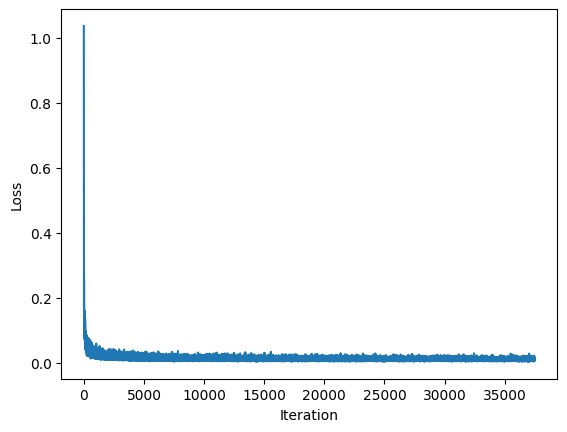

In [7]:
# plot losses
plt.plot(loss_lst)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [ ]:
g_model_path = './temp/Diffusion_00_Flowers102_models/'
g_video_path = './temp/Diffusion_00_Flowers102_videos/'
Path(g_model_path).mkdir(exist_ok=True, parents=True)
Path(g_video_path).mkdir(exist_ok=True, parents=True)


# parameters
batch_size = 4
epoches = 300
nb_images = 9
img_channel = 3

# datasets
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((128, 128),interpolation=transforms.InterpolationMode.BILINEAR, antialias=True)
            ])
dataset = datasets.Flowers102(root='./temp/data', split="train", download=True, transform=transform)
len(dataset)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Setup Model
model = UNet(in_ch = img_channel)
model.to(g_device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
diffusion_model = DiffusionModel(1000, model, g_device)

# Training
loss_lst = []
for ep in range(epoches):
    print(f"Epoch - {ep}")
    tq = tqdm(enumerate(dataloader), total = len(dataloader), desc="Training")
    for i, x0, in tq:
        x0 = x0[0].to(g_device)
        _loss = diffusion_model.training(x0, batch_size, optimizer)
        loss_lst.append(_loss)
        tq.set_description(f"Loss: {_loss:.5f}; step {i}; epoch {ep}")

    _model_path = os.path.join(g_model_path, f'unet_{ep:03d}.pth')
    torch.save(diffusion_model.function_approximator.state_dict(), _model_path)

    diffusion_model.function_approximator.eval()
    if ep % 5 == 0 or ep == epoches-1:
        _, t_list = diffusion_model.sampling(n_samples=nb_images, image_channels=img_channel, img_size=(128, 128))
        vfp = os.path.join(g_video_path, f"test_{ep:03d}.mp4")
        save_video(t_list, 3, 3, vfp)


    st = time.time()
    samples = diffusion_model.ddpm_sampling(n_samples=nb_images, image_channels=img_channel, img_size=(128, 128), use_tqdm=True)
    print(f"DDPM-Sampling {time.time() - st } seconds")
    img_op = os.path.join(g_video_path, f"ddpm_{ep:03d}.jpg")
    ts.save(samples, img_op, ncols = 3)

    st = time.time()
    samples = diffusion_model.ddim_sampling(n_samples=nb_images, image_channels=img_channel, img_size=(128, 128), use_tqdm=True)
    print(f"DDIM-Sampling {time.time() - st } seconds")
    img_op = os.path.join(g_video_path, f"ddim_{ep:03d}.jpg")
    ts.save(samples, img_op, ncols = 3)

    st = time.time()
    samples = diffusion_model.dpm_solver_sampling(n_samples=nb_images, n_steps=10, image_channels=img_channel, img_size=(128, 128), use_tqdm=True)
    print(f"DPM-Solver-Sampling {time.time() - st } seconds")
    img_op = os.path.join(g_video_path, f"dpm_solver_{ep:03d}.jpg")
    ts.save(samples, img_op, ncols = 3)


    diffusion_model.function_approximator.train()

plt.plot(loss_lst)
plt.show()


Epoch - 0


Sampling: 100%|██████████| 1000/1000 [06:48<00:00,  2.45it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/Diffusion_00_Flowers102_videos/test_000.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [06:46<00:00,  2.46it/s]


DDPM-Sampling 406.1644811630249 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:20<00:00,  2.46it/s]


DDIM-Sampling 20.295013904571533 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


DPM-Solver-Sampling 8.07364296913147 seconds
Epoch - 1


DDPM Sampling: 100%|██████████| 1000/1000 [06:55<00:00,  2.41it/s]


DDPM-Sampling 415.02939891815186 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:20<00:00,  2.42it/s]


DDIM-Sampling 20.683475971221924 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


DPM-Solver-Sampling 8.28880000114441 seconds
Epoch - 2


DDPM Sampling: 100%|██████████| 1000/1000 [06:49<00:00,  2.44it/s]


DDPM-Sampling 409.5543429851532 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:20<00:00,  2.48it/s]


DDIM-Sampling 20.187162160873413 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


DPM-Solver-Sampling 8.028548002243042 seconds
Epoch - 3


DDPM Sampling: 100%|██████████| 1000/1000 [06:51<00:00,  2.43it/s]


DDPM-Sampling 411.20798802375793 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:20<00:00,  2.48it/s]


DDIM-Sampling 20.145262002944946 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


DPM-Solver-Sampling 8.118782043457031 seconds
Epoch - 4


DDPM Sampling: 100%|██████████| 1000/1000 [06:50<00:00,  2.44it/s]


DDPM-Sampling 410.3764269351959 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:20<00:00,  2.47it/s]


DDIM-Sampling 20.25668501853943 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


DPM-Solver-Sampling 8.072882890701294 seconds
Epoch - 5


Sampling: 100%|██████████| 1000/1000 [07:22<00:00,  2.26it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/Diffusion_00_Flowers102_videos/test_005.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [07:19<00:00,  2.28it/s]


DDPM-Sampling 439.47158908843994 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


DDIM-Sampling 22.504366874694824 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


DPM-Solver-Sampling 9.12004804611206 seconds
Epoch - 6


DDPM Sampling: 100%|██████████| 1000/1000 [07:36<00:00,  2.19it/s]


DDPM-Sampling 456.99742603302 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


DDIM-Sampling 22.680628776550293 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


DPM-Solver-Sampling 9.04681396484375 seconds
Epoch - 7


DDPM Sampling: 100%|██████████| 1000/1000 [07:11<00:00,  2.32it/s]


DDPM-Sampling 431.7537829875946 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:21<00:00,  2.35it/s]


DDIM-Sampling 21.30805802345276 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


DPM-Solver-Sampling 8.488759994506836 seconds
Epoch - 8


DDPM Sampling: 100%|██████████| 1000/1000 [07:18<00:00,  2.28it/s]


DDPM-Sampling 438.50798201560974 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:21<00:00,  2.37it/s]


DDIM-Sampling 21.083595991134644 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


DPM-Solver-Sampling 8.646073818206787 seconds
Epoch - 9


DDPM Sampling: 100%|██████████| 1000/1000 [07:19<00:00,  2.27it/s]


DDPM-Sampling 439.83341002464294 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:23<00:00,  2.09it/s]


DDIM-Sampling 23.887830018997192 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


DPM-Solver-Sampling 9.528031826019287 seconds
Epoch - 10


Sampling: 100%|██████████| 1000/1000 [08:53<00:00,  1.87it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/Diffusion_00_Flowers102_videos/test_010.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [08:38<00:00,  1.93it/s]


DDPM-Sampling 518.5323910713196 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


DDIM-Sampling 26.543161153793335 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


DPM-Solver-Sampling 10.755922317504883 seconds
Epoch - 11


DDPM Sampling: 100%|██████████| 1000/1000 [08:01<00:00,  2.07it/s]


DDPM-Sampling 481.92977714538574 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:20<00:00,  2.47it/s]


DDIM-Sampling 20.236947059631348 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


DPM-Solver-Sampling 7.980085849761963 seconds
Epoch - 12


DDPM Sampling: 100%|██████████| 1000/1000 [06:56<00:00,  2.40it/s]


DDPM-Sampling 416.75721192359924 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:20<00:00,  2.48it/s]


DDIM-Sampling 20.19573402404785 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


DPM-Solver-Sampling 8.104428052902222 seconds
Epoch - 13


DDPM Sampling: 100%|██████████| 1000/1000 [06:59<00:00,  2.39it/s]


DDPM-Sampling 419.0756001472473 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:20<00:00,  2.42it/s]


DDIM-Sampling 20.699844121932983 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


DPM-Solver-Sampling 8.291000127792358 seconds
Epoch - 14


DDPM Sampling: 100%|██████████| 1000/1000 [06:58<00:00,  2.39it/s]


DDPM-Sampling 418.0519449710846 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


DDIM-Sampling 21.157274961471558 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


DPM-Solver-Sampling 8.335824966430664 seconds
Epoch - 15


Sampling: 100%|██████████| 1000/1000 [06:57<00:00,  2.40it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/Diffusion_00_Flowers102_videos/test_015.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [06:56<00:00,  2.40it/s]


DDPM-Sampling 416.4723491668701 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:20<00:00,  2.43it/s]


DDIM-Sampling 20.544827938079834 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


DPM-Solver-Sampling 8.191488027572632 seconds
Epoch - 16


DDPM Sampling: 100%|██████████| 1000/1000 [06:53<00:00,  2.42it/s]


DDPM-Sampling 413.0725498199463 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:20<00:00,  2.44it/s]


DDIM-Sampling 20.523418188095093 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


DPM-Solver-Sampling 8.112560987472534 seconds
Epoch - 17


DDPM Sampling: 100%|██████████| 1000/1000 [06:50<00:00,  2.44it/s]


DDPM-Sampling 410.51735615730286 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:20<00:00,  2.47it/s]


DDIM-Sampling 20.243669986724854 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


DPM-Solver-Sampling 8.030053853988647 seconds
Epoch - 18


DDPM Sampling: 100%|██████████| 1000/1000 [06:47<00:00,  2.46it/s]


DDPM-Sampling 407.1457369327545 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:20<00:00,  2.47it/s]


DDIM-Sampling 20.221363067626953 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


DPM-Solver-Sampling 8.04508900642395 seconds
Epoch - 19


DDPM Sampling: 100%|██████████| 1000/1000 [06:46<00:00,  2.46it/s]


DDPM-Sampling 406.4513337612152 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:20<00:00,  2.48it/s]


DDIM-Sampling 20.182181119918823 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


DPM-Solver-Sampling 8.058776140213013 seconds
Epoch - 20


Sampling: 100%|██████████| 1000/1000 [06:48<00:00,  2.45it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/Diffusion_00_Flowers102_videos/test_020.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [06:36<00:00,  2.52it/s]


DDPM-Sampling 396.1886169910431 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:19<00:00,  2.60it/s]


DDIM-Sampling 19.26153588294983 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


DPM-Solver-Sampling 7.67830228805542 seconds
Epoch - 21


DDPM Sampling: 100%|██████████| 1000/1000 [06:30<00:00,  2.56it/s]


DDPM-Sampling 390.10423493385315 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:19<00:00,  2.59it/s]


DDIM-Sampling 19.30052614212036 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


DPM-Solver-Sampling 7.745924949645996 seconds
Epoch - 22


DDPM Sampling: 100%|██████████| 1000/1000 [06:31<00:00,  2.55it/s]


DDPM-Sampling 391.54403138160706 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:19<00:00,  2.58it/s]


DDIM-Sampling 19.411438941955566 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


DPM-Solver-Sampling 7.708977222442627 seconds
Epoch - 23


DDPM Sampling: 100%|██████████| 1000/1000 [06:33<00:00,  2.54it/s]


DDPM-Sampling 393.04846382141113 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:19<00:00,  2.51it/s]


DDIM-Sampling 19.888524055480957 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


DPM-Solver-Sampling 7.873725175857544 seconds
Epoch - 24


DDPM Sampling: 100%|██████████| 1000/1000 [06:54<00:00,  2.41it/s]


DDPM-Sampling 414.6264340877533 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:20<00:00,  2.49it/s]


DDIM-Sampling 20.11692786216736 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


DPM-Solver-Sampling 8.006548166275024 seconds
Epoch - 25


Sampling: 100%|██████████| 1000/1000 [06:58<00:00,  2.39it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/Diffusion_00_Flowers102_videos/test_025.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [06:52<00:00,  2.43it/s]


DDPM-Sampling 412.31135988235474 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:20<00:00,  2.47it/s]


DDIM-Sampling 20.270843744277954 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


DPM-Solver-Sampling 8.097244024276733 seconds
Epoch - 26


DDPM Sampling: 100%|██████████| 1000/1000 [06:50<00:00,  2.44it/s]


DDPM-Sampling 410.271283864975 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:20<00:00,  2.43it/s]


DDIM-Sampling 20.554867267608643 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


DPM-Solver-Sampling 8.176482200622559 seconds
Epoch - 27


DDPM Sampling: 100%|██████████| 1000/1000 [06:52<00:00,  2.42it/s]


DDPM-Sampling 412.95701599121094 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:20<00:00,  2.44it/s]


DDIM-Sampling 20.494574069976807 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


DPM-Solver-Sampling 8.178356885910034 seconds
Epoch - 28


DDPM Sampling: 100%|██████████| 1000/1000 [06:48<00:00,  2.45it/s]


DDPM-Sampling 408.9362881183624 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:20<00:00,  2.47it/s]


DDIM-Sampling 20.27479100227356 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


DPM-Solver-Sampling 8.058531045913696 seconds
Epoch - 29


DDPM Sampling: 100%|██████████| 1000/1000 [06:47<00:00,  2.45it/s]


DDPM-Sampling 407.6094169616699 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:19<00:00,  2.59it/s]


DDIM-Sampling 19.28113102912903 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


DPM-Solver-Sampling 7.709111213684082 seconds
Epoch - 30


Sampling: 100%|██████████| 1000/1000 [06:51<00:00,  2.43it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/Diffusion_00_Flowers102_videos/test_030.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [06:54<00:00,  2.41it/s]


DDPM-Sampling 414.550714969635 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:20<00:00,  2.43it/s]


DDIM-Sampling 20.611860036849976 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


DPM-Solver-Sampling 8.169450998306274 seconds
Epoch - 31


DDPM Sampling: 100%|██████████| 1000/1000 [06:54<00:00,  2.41it/s]


DDPM-Sampling 414.32363176345825 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:20<00:00,  2.43it/s]


DDIM-Sampling 20.607863903045654 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


DPM-Solver-Sampling 8.20370888710022 seconds
Epoch - 32


DDPM Sampling: 100%|██████████| 1000/1000 [06:52<00:00,  2.42it/s]


DDPM-Sampling 412.5996530056 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:20<00:00,  2.43it/s]


DDIM-Sampling 20.587893962860107 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


DPM-Solver-Sampling 8.194983005523682 seconds
Epoch - 33


DDPM Sampling: 100%|██████████| 1000/1000 [06:54<00:00,  2.41it/s]


DDPM-Sampling 414.7663450241089 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:20<00:00,  2.46it/s]


DDIM-Sampling 20.35706901550293 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


DPM-Solver-Sampling 8.101631879806519 seconds
Epoch - 34


DDPM Sampling: 100%|██████████| 1000/1000 [06:53<00:00,  2.42it/s]


DDPM-Sampling 413.4474630355835 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:20<00:00,  2.44it/s]


DDIM-Sampling 20.492908000946045 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


DPM-Solver-Sampling 8.163821935653687 seconds
Epoch - 35


Sampling: 100%|██████████| 1000/1000 [06:33<00:00,  2.54it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/Diffusion_00_Flowers102_videos/test_035.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [06:30<00:00,  2.56it/s]


DDPM-Sampling 390.52558398246765 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:19<00:00,  2.59it/s]


DDIM-Sampling 19.30867886543274 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


DPM-Solver-Sampling 7.655313968658447 seconds
Epoch - 36


DDPM Sampling: 100%|██████████| 1000/1000 [06:34<00:00,  2.53it/s]


DDPM-Sampling 394.6768081188202 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:20<00:00,  2.48it/s]


DDIM-Sampling 20.12383794784546 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


DPM-Solver-Sampling 8.098071098327637 seconds
Epoch - 37


DDPM Sampling: 100%|██████████| 1000/1000 [06:39<00:00,  2.51it/s]


DDPM-Sampling 399.1573209762573 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


DDIM-Sampling 19.63435983657837 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


DPM-Solver-Sampling 7.783454895019531 seconds
Epoch - 38


DDPM Sampling: 100%|██████████| 1000/1000 [06:39<00:00,  2.50it/s]


DDPM-Sampling 399.98170804977417 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:19<00:00,  2.53it/s]


DDIM-Sampling 19.760639905929565 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


DPM-Solver-Sampling 7.8872010707855225 seconds
Epoch - 39


DDPM Sampling: 100%|██████████| 1000/1000 [06:39<00:00,  2.50it/s]


DDPM-Sampling 399.73673605918884 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:19<00:00,  2.52it/s]


DDIM-Sampling 19.822954177856445 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


DPM-Solver-Sampling 7.873316764831543 seconds
Epoch - 40


Sampling: 100%|██████████| 1000/1000 [06:38<00:00,  2.51it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/Diffusion_00_Flowers102_videos/test_040.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [06:41<00:00,  2.49it/s]


DDPM-Sampling 401.8916082382202 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:19<00:00,  2.53it/s]


DDIM-Sampling 19.78230309486389 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


DPM-Solver-Sampling 7.888342618942261 seconds
Epoch - 41


DDPM Sampling: 100%|██████████| 1000/1000 [06:46<00:00,  2.46it/s]


DDPM-Sampling 406.7910017967224 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:20<00:00,  2.48it/s]


DDIM-Sampling 20.138390064239502 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


DPM-Solver-Sampling 7.961465120315552 seconds
Epoch - 42


DDPM Sampling: 100%|██████████| 1000/1000 [06:31<00:00,  2.55it/s]


DDPM-Sampling 391.413950920105 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:19<00:00,  2.57it/s]


DDIM-Sampling 19.45935606956482 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


DPM-Solver-Sampling 7.741911888122559 seconds
Epoch - 43


DDPM Sampling: 100%|██████████| 1000/1000 [06:43<00:00,  2.48it/s]


DDPM-Sampling 403.23763608932495 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:20<00:00,  2.47it/s]


DDIM-Sampling 20.27910017967224 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


DPM-Solver-Sampling 8.019065141677856 seconds
Epoch - 44


DDPM Sampling: 100%|██████████| 1000/1000 [06:43<00:00,  2.48it/s]


DDPM-Sampling 403.46171593666077 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:20<00:00,  2.46it/s]


DDIM-Sampling 20.303313970565796 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


DPM-Solver-Sampling 8.09656286239624 seconds
Epoch - 45


Sampling: 100%|██████████| 1000/1000 [06:45<00:00,  2.46it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/Diffusion_00_Flowers102_videos/test_045.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [06:41<00:00,  2.49it/s]


DDPM-Sampling 401.59079098701477 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:19<00:00,  2.54it/s]


DDIM-Sampling 19.714313983917236 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


DPM-Solver-Sampling 7.7820000648498535 seconds
Epoch - 46


DDPM Sampling: 100%|██████████| 1000/1000 [06:37<00:00,  2.51it/s]


DDPM-Sampling 397.7825300693512 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:19<00:00,  2.52it/s]


DDIM-Sampling 19.8490629196167 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


DPM-Solver-Sampling 7.874610900878906 seconds
Epoch - 47


DDPM Sampling: 100%|██████████| 1000/1000 [06:35<00:00,  2.53it/s]


DDPM-Sampling 395.4568419456482 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:19<00:00,  2.54it/s]


DDIM-Sampling 19.713093996047974 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


DPM-Solver-Sampling 7.819947004318237 seconds
Epoch - 48


DDPM Sampling: 100%|██████████| 1000/1000 [06:39<00:00,  2.50it/s]


DDPM-Sampling 399.2422740459442 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:19<00:00,  2.51it/s]


DDIM-Sampling 19.909868717193604 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


DPM-Solver-Sampling 7.9114508628845215 seconds
Epoch - 49


DDPM Sampling: 100%|██████████| 1000/1000 [06:36<00:00,  2.52it/s]


DDPM-Sampling 396.7050368785858 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


DDIM-Sampling 19.590363264083862 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


DPM-Solver-Sampling 7.8850929737091064 seconds
Epoch - 50


Sampling: 100%|██████████| 1000/1000 [06:35<00:00,  2.53it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/Diffusion_00_Flowers102_videos/test_050.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [06:32<00:00,  2.55it/s]


DDPM-Sampling 392.8581349849701 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:19<00:00,  2.59it/s]


DDIM-Sampling 19.280019998550415 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


DPM-Solver-Sampling 7.588593006134033 seconds
Epoch - 51


DDPM Sampling: 100%|██████████| 1000/1000 [06:22<00:00,  2.61it/s]


DDPM-Sampling 382.6982419490814 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.64it/s]


DDIM-Sampling 18.956292152404785 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


DPM-Solver-Sampling 7.527052879333496 seconds
Epoch - 52


DDPM Sampling: 100%|██████████| 1000/1000 [06:23<00:00,  2.61it/s]


DDPM-Sampling 383.6066508293152 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:19<00:00,  2.60it/s]


DDIM-Sampling 19.263365030288696 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


DPM-Solver-Sampling 7.6505420207977295 seconds
Epoch - 53


DDPM Sampling: 100%|██████████| 1000/1000 [06:24<00:00,  2.60it/s]


DDPM-Sampling 384.68214297294617 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:19<00:00,  2.62it/s]


DDIM-Sampling 19.070024013519287 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


DPM-Solver-Sampling 7.623341798782349 seconds
Epoch - 54


DDPM Sampling: 100%|██████████| 1000/1000 [06:20<00:00,  2.63it/s]


DDPM-Sampling 380.59794783592224 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.65it/s]


DDIM-Sampling 18.88421392440796 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


DPM-Solver-Sampling 7.491219997406006 seconds
Epoch - 55


Sampling: 100%|██████████| 1000/1000 [06:17<00:00,  2.65it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/Diffusion_00_Flowers102_videos/test_055.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [06:16<00:00,  2.65it/s]


DDPM-Sampling 376.8425679206848 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.66it/s]


DDIM-Sampling 18.809988021850586 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


DPM-Solver-Sampling 7.460370063781738 seconds
Epoch - 56


DDPM Sampling: 100%|██████████| 1000/1000 [06:19<00:00,  2.63it/s]


DDPM-Sampling 379.85496401786804 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.66it/s]


DDIM-Sampling 18.816378831863403 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


DPM-Solver-Sampling 7.466152191162109 seconds
Epoch - 57


DDPM Sampling: 100%|██████████| 1000/1000 [06:17<00:00,  2.65it/s]


DDPM-Sampling 377.5840039253235 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.67it/s]


DDIM-Sampling 18.728181838989258 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


DPM-Solver-Sampling 7.472069025039673 seconds
Epoch - 58


DDPM Sampling: 100%|██████████| 1000/1000 [06:18<00:00,  2.64it/s]


DDPM-Sampling 378.1040508747101 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.64it/s]


DDIM-Sampling 18.91729712486267 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


DPM-Solver-Sampling 7.5071539878845215 seconds
Epoch - 59


DDPM Sampling: 100%|██████████| 1000/1000 [06:18<00:00,  2.64it/s]


DDPM-Sampling 378.7821309566498 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.67it/s]


DDIM-Sampling 18.706775903701782 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


DPM-Solver-Sampling 7.424315929412842 seconds
Epoch - 60


Sampling: 100%|██████████| 1000/1000 [06:21<00:00,  2.62it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/Diffusion_00_Flowers102_videos/test_060.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [06:19<00:00,  2.63it/s]


DDPM-Sampling 379.939505815506 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.65it/s]


DDIM-Sampling 18.88819408416748 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


DPM-Solver-Sampling 7.541383981704712 seconds
Epoch - 61


DDPM Sampling: 100%|██████████| 1000/1000 [06:16<00:00,  2.66it/s]


DDPM-Sampling 376.64496874809265 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.65it/s]


DDIM-Sampling 18.84451913833618 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


DPM-Solver-Sampling 7.4811060428619385 seconds
Epoch - 62


DDPM Sampling: 100%|██████████| 1000/1000 [06:18<00:00,  2.64it/s]


DDPM-Sampling 378.6948161125183 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.65it/s]


DDIM-Sampling 18.902880668640137 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


DPM-Solver-Sampling 7.568017244338989 seconds
Epoch - 63


DDPM Sampling: 100%|██████████| 1000/1000 [06:17<00:00,  2.65it/s]


DDPM-Sampling 377.2522962093353 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.65it/s]


DDIM-Sampling 18.886948823928833 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


DPM-Solver-Sampling 7.470533847808838 seconds
Epoch - 64


DDPM Sampling: 100%|██████████| 1000/1000 [06:19<00:00,  2.63it/s]


DDPM-Sampling 379.762570142746 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.63it/s]


DDIM-Sampling 18.994822025299072 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


DPM-Solver-Sampling 7.556766033172607 seconds
Epoch - 65


Sampling: 100%|██████████| 1000/1000 [06:19<00:00,  2.64it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/Diffusion_00_Flowers102_videos/test_065.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [06:16<00:00,  2.66it/s]


DDPM-Sampling 376.55677318573 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.68it/s]


DDIM-Sampling 18.629842042922974 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


DPM-Solver-Sampling 7.403386831283569 seconds
Epoch - 66


DDPM Sampling: 100%|██████████| 1000/1000 [06:16<00:00,  2.65it/s]


DDPM-Sampling 376.93357610702515 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.65it/s]


DDIM-Sampling 18.84535026550293 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


DPM-Solver-Sampling 7.461480140686035 seconds
Epoch - 67


DDPM Sampling: 100%|██████████| 1000/1000 [06:13<00:00,  2.67it/s]


DDPM-Sampling 373.96207094192505 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.69it/s]


DDIM-Sampling 18.60787296295166 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


DPM-Solver-Sampling 7.383155107498169 seconds
Epoch - 68


DDPM Sampling: 100%|██████████| 1000/1000 [06:16<00:00,  2.66it/s]


DDPM-Sampling 376.3188650608063 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.68it/s]


DDIM-Sampling 18.672863006591797 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


DPM-Solver-Sampling 7.410090923309326 seconds
Epoch - 69


DDPM Sampling: 100%|██████████| 1000/1000 [06:15<00:00,  2.66it/s]


DDPM-Sampling 375.9157991409302 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.68it/s]


DDIM-Sampling 18.677129983901978 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


DPM-Solver-Sampling 7.38068413734436 seconds
Epoch - 70


Sampling: 100%|██████████| 1000/1000 [06:16<00:00,  2.66it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/Diffusion_00_Flowers102_videos/test_070.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [06:16<00:00,  2.65it/s]


DDPM-Sampling 376.93739914894104 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.67it/s]


DDIM-Sampling 18.70380997657776 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


DPM-Solver-Sampling 7.3886260986328125 seconds
Epoch - 71


DDPM Sampling: 100%|██████████| 1000/1000 [06:14<00:00,  2.67it/s]


DDPM-Sampling 374.53018593788147 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.68it/s]


DDIM-Sampling 18.635957956314087 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


DPM-Solver-Sampling 7.39792799949646 seconds
Epoch - 72


DDPM Sampling: 100%|██████████| 1000/1000 [06:26<00:00,  2.59it/s]


DDPM-Sampling 386.8436779975891 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:19<00:00,  2.54it/s]


DDIM-Sampling 19.666768074035645 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


DPM-Solver-Sampling 7.743221998214722 seconds
Epoch - 73


DDPM Sampling: 100%|██████████| 1000/1000 [06:22<00:00,  2.61it/s]


DDPM-Sampling 382.5545926094055 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:19<00:00,  2.62it/s]


DDIM-Sampling 19.098212242126465 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


DPM-Solver-Sampling 7.614508152008057 seconds
Epoch - 74


DDPM Sampling: 100%|██████████| 1000/1000 [06:20<00:00,  2.63it/s]


DDPM-Sampling 380.5723612308502 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:19<00:00,  2.62it/s]


DDIM-Sampling 19.108161687850952 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


DPM-Solver-Sampling 7.582992076873779 seconds
Epoch - 75


Sampling: 100%|██████████| 1000/1000 [06:23<00:00,  2.61it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/Diffusion_00_Flowers102_videos/test_075.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [06:19<00:00,  2.63it/s]


DDPM-Sampling 379.75753688812256 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.64it/s]


DDIM-Sampling 18.965425968170166 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


DPM-Solver-Sampling 7.542363882064819 seconds
Epoch - 76


DDPM Sampling: 100%|██████████| 1000/1000 [06:20<00:00,  2.63it/s]


DDPM-Sampling 380.4284510612488 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:19<00:00,  2.62it/s]


DDIM-Sampling 19.110838174819946 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


DPM-Solver-Sampling 7.589469909667969 seconds
Epoch - 77


DDPM Sampling: 100%|██████████| 1000/1000 [06:20<00:00,  2.63it/s]


DDPM-Sampling 380.6125819683075 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.63it/s]


DDIM-Sampling 18.994571924209595 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


DPM-Solver-Sampling 7.617223024368286 seconds
Epoch - 78


DDPM Sampling: 100%|██████████| 1000/1000 [06:18<00:00,  2.64it/s]


DDPM-Sampling 378.8798050880432 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.72it/s]


DDIM-Sampling 18.386085271835327 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


DPM-Solver-Sampling 7.313424110412598 seconds
Epoch - 79


DDPM Sampling: 100%|██████████| 1000/1000 [06:11<00:00,  2.69it/s]


DDPM-Sampling 371.20549297332764 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.69it/s]


DDIM-Sampling 18.576612949371338 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


DPM-Solver-Sampling 7.358388900756836 seconds
Epoch - 80


Sampling: 100%|██████████| 1000/1000 [06:12<00:00,  2.68it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/Diffusion_00_Flowers102_videos/test_080.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [06:11<00:00,  2.69it/s]


DDPM-Sampling 371.9545168876648 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.71it/s]


DDIM-Sampling 18.424354076385498 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


DPM-Solver-Sampling 7.293688058853149 seconds
Epoch - 81


DDPM Sampling: 100%|██████████| 1000/1000 [06:11<00:00,  2.69it/s]


DDPM-Sampling 371.9010248184204 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.72it/s]


DDIM-Sampling 18.363929271697998 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


DPM-Solver-Sampling 7.255774021148682 seconds
Epoch - 82


DDPM Sampling: 100%|██████████| 1000/1000 [06:10<00:00,  2.70it/s]


DDPM-Sampling 370.75735092163086 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.73it/s]


DDIM-Sampling 18.346681833267212 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


DPM-Solver-Sampling 7.235815763473511 seconds
Epoch - 83


DDPM Sampling: 100%|██████████| 1000/1000 [06:10<00:00,  2.70it/s]


DDPM-Sampling 370.3981237411499 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.74it/s]


DDIM-Sampling 18.226305961608887 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


DPM-Solver-Sampling 7.257576942443848 seconds
Epoch - 84


DDPM Sampling: 100%|██████████| 1000/1000 [06:08<00:00,  2.71it/s]


DDPM-Sampling 368.5081558227539 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.73it/s]


DDIM-Sampling 18.302329063415527 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


DPM-Solver-Sampling 7.173105001449585 seconds
Epoch - 85


Sampling: 100%|██████████| 1000/1000 [06:08<00:00,  2.71it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/Diffusion_00_Flowers102_videos/test_085.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [06:08<00:00,  2.71it/s]


DDPM-Sampling 368.98234605789185 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.73it/s]


DDIM-Sampling 18.3497052192688 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


DPM-Solver-Sampling 7.318145990371704 seconds
Epoch - 86


DDPM Sampling: 100%|██████████| 1000/1000 [06:09<00:00,  2.71it/s]


DDPM-Sampling 369.1502432823181 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.73it/s]


DDIM-Sampling 18.29369807243347 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


DPM-Solver-Sampling 7.284152030944824 seconds
Epoch - 87


DDPM Sampling: 100%|██████████| 1000/1000 [06:07<00:00,  2.72it/s]


DDPM-Sampling 367.14317893981934 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.75it/s]


DDIM-Sampling 18.155051708221436 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


DPM-Solver-Sampling 7.27531099319458 seconds
Epoch - 88


DDPM Sampling: 100%|██████████| 1000/1000 [06:10<00:00,  2.70it/s]


DDPM-Sampling 370.495817899704 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.64it/s]


DDIM-Sampling 18.934260845184326 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


DPM-Solver-Sampling 7.521398067474365 seconds
Epoch - 89


DDPM Sampling: 100%|██████████| 1000/1000 [06:19<00:00,  2.63it/s]


DDPM-Sampling 379.58581924438477 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.67it/s]


DDIM-Sampling 18.711528301239014 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


DPM-Solver-Sampling 7.5272650718688965 seconds
Epoch - 90


Sampling: 100%|██████████| 1000/1000 [06:20<00:00,  2.63it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/Diffusion_00_Flowers102_videos/test_090.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [06:19<00:00,  2.64it/s]


DDPM-Sampling 379.1844789981842 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.64it/s]


DDIM-Sampling 18.967570304870605 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


DPM-Solver-Sampling 7.494822978973389 seconds
Epoch - 91


DDPM Sampling: 100%|██████████| 1000/1000 [06:25<00:00,  2.59it/s]


DDPM-Sampling 385.3895196914673 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.66it/s]


DDIM-Sampling 18.829739093780518 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


DPM-Solver-Sampling 7.441558122634888 seconds
Epoch - 92


DDPM Sampling: 100%|██████████| 1000/1000 [06:25<00:00,  2.60it/s]


DDPM-Sampling 385.30113887786865 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:19<00:00,  2.58it/s]


DDIM-Sampling 19.395798921585083 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


DPM-Solver-Sampling 7.662421941757202 seconds
Epoch - 93


DDPM Sampling: 100%|██████████| 1000/1000 [06:19<00:00,  2.63it/s]


DDPM-Sampling 379.53323197364807 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.64it/s]


DDIM-Sampling 18.970234870910645 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


DPM-Solver-Sampling 7.548167943954468 seconds
Epoch - 94


DDPM Sampling: 100%|██████████| 1000/1000 [06:19<00:00,  2.63it/s]


DDPM-Sampling 379.95803809165955 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.65it/s]


DDIM-Sampling 18.874040126800537 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


DPM-Solver-Sampling 7.481777906417847 seconds
Epoch - 95


Sampling: 100%|██████████| 1000/1000 [06:21<00:00,  2.62it/s]
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/Diffusion_00_Flowers102_videos/test_095.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [06:23<00:00,  2.61it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:119: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize, dpi=dpi)


DDPM-Sampling 383.67966890335083 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:19<00:00,  2.63it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:119: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize, dpi=dpi)


DDIM-Sampling 19.034153938293457 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:119: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize, dpi=dpi)


DPM-Solver-Sampling 7.647589921951294 seconds
Epoch - 96


DDPM Sampling: 100%|██████████| 1000/1000 [06:23<00:00,  2.61it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:119: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize, dpi=dpi)


DDPM-Sampling 383.80876326560974 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:19<00:00,  2.63it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:119: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize, dpi=dpi)


DDIM-Sampling 19.008463144302368 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:119: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize, dpi=dpi)


DPM-Solver-Sampling 7.532088994979858 seconds
Epoch - 97


DDPM Sampling: 100%|██████████| 1000/1000 [06:21<00:00,  2.62it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:119: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize, dpi=dpi)


DDPM-Sampling 381.9513840675354 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:19<00:00,  2.62it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:119: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize, dpi=dpi)


DDIM-Sampling 19.05721688270569 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:119: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize, dpi=dpi)


DPM-Solver-Sampling 7.5347580909729 seconds
Epoch - 98


DDPM Sampling: 100%|██████████| 1000/1000 [06:23<00:00,  2.61it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:119: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize, dpi=dpi)


DDPM-Sampling 383.5997083187103 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:19<00:00,  2.59it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:119: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize, dpi=dpi)


DDIM-Sampling 19.272657871246338 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:119: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize, dpi=dpi)


DPM-Solver-Sampling 7.64202880859375 seconds
Epoch - 99


DDPM Sampling: 100%|██████████| 1000/1000 [06:25<00:00,  2.59it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:119: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize, dpi=dpi)


DDPM-Sampling 385.59471702575684 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:19<00:00,  2.61it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:119: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize, dpi=dpi)


DDIM-Sampling 19.168287992477417 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]
/Users/hyunjae.k/110_HyunJae_Git/2025_Drills/.venv/lib/python3.10/site-packages/torchshow/visualization.py:119: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize, dpi=dpi)


DPM-Solver-Sampling 7.603333234786987 seconds
Epoch - 100


Sampling: 100%|██████████| 1000/1000 [06:31<00:00,  2.55it/s]
/var/folders/xk/hd_6wmxj32ngdnnm2x5h1_7r0000gn/T/ipykernel_4723/510747069.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows, ncols)
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./temp/Diffusion_00_Flowers102_videos/test_100.mp4
DDPM Sampling: 100%|██████████| 1000/1000 [06:16<00:00,  2.66it/s]


DDPM-Sampling 376.5493528842926 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.66it/s]


DDIM-Sampling 18.805335998535156 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


DPM-Solver-Sampling 7.487132787704468 seconds
Epoch - 101


DDPM Sampling: 100%|██████████| 1000/1000 [06:21<00:00,  2.62it/s]


DDPM-Sampling 381.5744800567627 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.64it/s]


DDIM-Sampling 18.965942859649658 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


DPM-Solver-Sampling 7.495873928070068 seconds
Epoch - 102


DDPM Sampling: 100%|██████████| 1000/1000 [06:21<00:00,  2.62it/s]


DDPM-Sampling 381.7405779361725 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:19<00:00,  2.62it/s]


DDIM-Sampling 19.0888729095459 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


DPM-Solver-Sampling 7.50898003578186 seconds
Epoch - 103


DDPM Sampling: 100%|██████████| 1000/1000 [06:19<00:00,  2.64it/s]


DDPM-Sampling 379.2569389343262 seconds


DDIM Sampling: 100%|██████████| 50/50 [00:18<00:00,  2.66it/s]


DDIM-Sampling 18.82077693939209 seconds


DPM-Solver Sampling: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


DPM-Solver-Sampling 7.527062177658081 seconds
Epoch - 104


DDPM Sampling:  41%|████      | 409/1000 [02:36<03:48,  2.59it/s]

In [ ]:
# plot losses
plt.plot(loss_lst)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()